# Dynamic Programming project

In [406]:
import numpy as np
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim

from scipy.optimize import fminbound
from plot_functions import plot_graph
from torchsummary import summary


In [220]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsummary
from d2l import torch as d2l

Consider an agent who allocates her time between producing the consumption good and accumulating human capital.
The agent seeks to maximize her discounted utility, as captured by the following objective:

$$
\max_{\{C_t\}_{t=0}^\infty} \sum_{t=0}^\infty \beta^t \, U(C_t)
$$

subject to:

$$ (i)\quad C_t = H_t^\alpha \, L_t, $$
$$ (ii)\quad H_t = (1 - \delta) H_{t-1} + (1 - L_{t-1}), $$
$$ (iii)\quad L_t \in [0,1]. $$


# 1. Approximation of the value function

$$
V(H_t) = \max_{L_t \in [0,1]} [ U(C_t) + \beta V(H_{t+1})] \\
$$

In [221]:
def utility(c, sigma=0.9):
    if sigma!=1:
        return (c**(1 - sigma)) / (1 - sigma)
    else:
        return np.log(c)

def consumption(H,L,alpha=0.4):
    return (H**alpha) * L

def human_capital_accumulation(H,L,delta=0.05):
    return (1 - delta) * H + (1 - L)

def labor_supply(H,H_next, delta=0.05):
    return (1 - delta) * H + 1 - H_next

def bellman_equation(C, H_next, H_values, V, beta=0.9):
    return utility(C) + beta * np.interp(H_next, H_values, V)

def objective(L, H, V, H_values):
    C = consumption(H,L)
    H_next = human_capital_accumulation(H,L)
    value = bellman_equation(C, H_next, H_values, V)
    return - value

def compute_value_function(V, H_values, H_min=0.1, H_max=5.0):
    new_V = np.zeros_like(V)
    policy = np.zeros_like(V)

    for i, H in enumerate(H_values):
        L = fminbound(objective, 0, 1, args=(H, V, H_values))
        C = consumption(H,L)
        H_next = human_capital_accumulation(H,L)
        value = bellman_equation(C, H_next, H_values, V)
        new_V[i], policy[i] = value, H_next
    return new_V, policy

def value_function_iteration(tolerance=1e-4, max_iterations=500, H_min=0.1, H_max=5, H_points=200):
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)

    for iteration in range(max_iterations):
        new_V, policy = compute_value_function(V, H_values)

        if np.max(np.abs(new_V - V)) < tolerance:
            print(f"Converged in {iteration} iterations")
            break
        V = new_V
    return V, policy

In [222]:
V, optimal_policy = value_function_iteration()

Converged in 110 iterations


# 2. Graphics

## 2.1 Value function

In [250]:
H_min, H_max, H_points = 0.1, 5, 200
H_values = np.linspace(H_min, H_max, H_points)

plot_graph(
    variable1 = (H_values, V, "approximated value function"),
    xaxis_title='Human Capital (H)',
    yaxis_title='Value Function',
    title="Approximation of the Value Function<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>"
)

Each point of the value function represents the maximum lifetime utility the agent can achieve starting with a specific level of human capital. 

## 2.2 Policy function

The policy function is the relation between the Human Capital at time t+1 and a time t: 
$$
H_{t+1}(H_t)
$$

In [252]:
# optimal_H = human_capital_accumulation(H_values,optimal_policy)

plot_graph(
    variable1=(H_values, optimal_policy,"Human Capital accumulation"),
    variable2=(H_values, H_values, "45° line"),
    xaxis_title="Ht",
    yaxis_title="Ht+1",
    title="Optimal policy function Ht+1(Ht)",
    showlegend=True
)

## 2.3 Consumption C(H) and Labour Supply L(H)

In [225]:
# no_more_learning_point = H_values[np.where(optimal_policy==0.99)[0][0]]
optimal_L = labor_supply(H_values, optimal_policy)
optimal_C = consumption(H_values,optimal_L)

plot_graph(
    variable1=(H_values, optimal_L,"Labor Supply"),
    variable2=(H_values, optimal_C, "Consumption"),
    xaxis_title="Human Capital (H)",
    yaxis_title="",
    title="Consumption C(H) and Labour Supply L(H)",
    showlegend=True
)

## 2.5 Interpretation

For <b>low values of human capital</b>, the agent prioritizes investing time in human capital rather than spend too much time working with a low productivity: it is optimal for the agent to learn and become more skilled and productive in the future. 

For <b>high values of human capital</b> it is optimal for the agent to reduce the investment in human capital and spend most of his time producing. For level of human capital higher than 2.9, the agent should even stop learning new skill and profit from his high productivity by spending all his time producing the consumption good. 

Those results are explained by diminishing returns of human capital and the presence of a <b>steady state level of human capital</b>. In the simulations, the steady state is found at around 𝐻=2.2 at the intersection between the optimal policy and the 45° line. Agents adopting the optimal policy will tend to converge towards this steady state level: 
- For <b>levels of human capital below the steady state</b>, the agent increases his lifetime utility by investing in human capital, as the returns to learning outweigh the opportunity cost of forgone production.
- For <b>levels of human capital above the steady state</b>, the agent can increase his lifetime utility by producing and consuming more. He thus reduces his investment in human capital which will depreciate until reaching the steady state level.  

# 3. Compute the value function associated to any arbitrary policy

## 3.1 Arbitrary policy for labor allocation

In this section, we will study the policies of labor allocation specifing the agent's choice of labor allocation (Lt) for a given level of human capital (Ht). It refers to the relation between the control variable and the state variable:
$$
L_t^(H_t)
$$

Lets study the following arbitrary policy function: 
1. <b>Constant policy</b>: the agent allocate a constant fraction of its time to consumption production
$$
L_t(H_t) = c , \quad c \in [0,1]
$$
2. <b>Random policy</b>: the agent allocates labor randomly following a uniform law 
$$
L_t(H_t)∼U(0,1)
$$
3. <b>Proportional policy</b>: the agent allocates its time to consumption production proportionally to its human capital
$$
L_t(H_t) = \frac{H_t}{H_{max}}
$$

In [286]:
def constant_labor_policy(H, c=0.5):
    return np.full_like(H, c)

def random_labor_policy(H):
    np.random.seed(42)
    return np.random.uniform(0, 1, size=H.shape)

def proportional_labor_policy(H, H_max=5.0):
    if isinstance(H, (int, float)):
        return H / H_max
    return H / H_max

## 3.2 Approximate the value function for different labor allocation policies

In [255]:
def compute_value_function_with_arbitrary_policy(V, H_values, arbitrary_policy, alpha=0.4, delta=0.05, beta=0.9):
    """
    Evaluate the value function for a given lobor allocation policy.
    """
    new_V = np.zeros_like(V)
    for i, H in enumerate(H_values):
        L = arbitrary_policy[i]
        C = consumption(H, L, alpha)
        H_next = human_capital_accumulation(H, L, delta)
        new_V[i] = bellman_equation(C, H_next, H_values, V, beta)
    return new_V

def value_function_with_arbitrary_policy_iteration(arbitrary_policy, tolerance=1e-4, max_iterations=500, H_min=0.1, H_max=5, H_points=200):
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)

    for iteration in range(max_iterations):
        new_V = compute_value_function_with_arbitrary_policy(V, H_values, arbitrary_policy)

        if np.max(np.abs(new_V - V)) < tolerance:
            print(f"Converged in {iteration + 1} iterations")
            break
        V = new_V
    if iteration == (max_iterations-1):
        print(f'The value function iteration didn\'t converged after {max_iterations} iterations.')
    return V

In [285]:
# Compute the arbitrary policies of labor allocation
proportional_policy = proportional_labor_policy(H_values)
constant_policy = constant_labor_policy(H_values)
random_policy = random_labor_policy(H_values)

# Compute the value function associated to these policies
V_proportional = value_function_with_arbitrary_policy_iteration(arbitrary_policy=proportional_policy)
V_constant = value_function_with_arbitrary_policy_iteration(arbitrary_policy=constant_policy)
V_random = value_function_with_arbitrary_policy_iteration(arbitrary_policy=random_policy)

Converged in 111 iterations
Converged in 111 iterations
Converged in 111 iterations


In [248]:
plot_graph(
    variable1=(H_values, V,"Optimal policy"),
    variable2=(H_values, V_proportional,"Proportional L(Ht)"),
    variable3=(H_values, V_random, "Random L(Ht)"),
    variable4=(H_values, V_constant, "Constant L(Ht)"),
    xaxis_title="Ht",
    yaxis_title="Value function",
    title="Approximation of the Value Function for some different labor allocation policies<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

Some arbitrary policies of labor supply can lead to levels of human capital higher than the upper bound as shown in the following graph of the policy function Ht+1(Ht). 

In [246]:
H_constant = human_capital_accumulation(H_values,constant_policy)
H_random = human_capital_accumulation(H_values, random_policy)
H_proportional = human_capital_accumulation(H_values, proportional_policy)

plot_graph(
    variable1=(H_values, optimal_policy,"Optimal Policy"),
    variable2=(H_values, H_proportional,"Proportional Policy"),
    variable3=(H_values, H_random, "Random Policy"),
    variable4=(H_values, H_constant, "Constant Policy"),
    xaxis_title="Ht",
    yaxis_title="Ht+1",
    title="Policy function Ht+1(Ht) for different policies of labor supply allocation",
    showlegend=True
)

# 4. Implement a greedy procedure to update the policy function

## 4.1 Policy evaluation combined with a policy improvement procedure

In [311]:

def evaluate_and_improve_policy_function_until_convergence(tolerance=1e-4, max_iterations=500, H_min=0.1, H_max=5.0, H_points=200, alpha=0.4, delta=0.05, beta=0.9):
    " Iterate until convergence "
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)
    labor_policy = np.full(H_points, 0.5)  # Arbitrary constant initial policy L(H) = 0.5
    history = []

    for iteration in range(max_iterations):
        # Policy evaluation
        V_approx = compute_value_function_with_arbitrary_policy(V, H_values, labor_policy)
        # Policy improvment
        V_new, policy_new = compute_value_function(V_approx, H_values)
        labor_policy_new = labor_supply(H_values, policy_new)
        # Track value function evolution
        history.append(V_new)

        # if np.max(np.abs(labor_policy_new - labor_policy)) < tolerance:
        if np.max(np.abs(V_new - V_approx)) < tolerance:
            print(f"Converged in {iteration+1} iterations")
            break

        V = V_new
        labor_policy = labor_policy_new

    return V_new, labor_policy, history

In [312]:
V_improve, improved_policy, V_history = evaluate_and_improve_policy_function_until_convergence()

Converged in 56 iterations


In [313]:
plot_graph(
    variable1=(H_values, V, "Value function"),
    variable2=(H_values, V_improve, f"Value function at iteration {len(V_history)}"),
    variable3=(H_values, V_history[14], "Value function at iteration 15"),
    variable4=(H_values, V_history[24], "Value function at iteration 25"),
    xaxis_title="Human Capital (H)",
    yaxis_title="Value function",
    title="Value Function approximated with a greedy update of the policy function<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

## 4.2 Update the policy function with an epsilon-greedy procedure

In [245]:
def compute_greedy_procedure_value_function(V, H_values, arbitrary_policy, epsilon = 0.1, H_min=0.1, H_max=5.0):
    new_V = np.zeros_like(V)
    policy = np.zeros_like(V)

    for i, H in enumerate(H_values):

        if np.random.rand() < epsilon:
            L = arbitrary_policy[i]
            C = consumption(H,L)
            H_next = human_capital_accumulation(H,L)
            value = bellman_equation(C, H_next, H_values, V)

        else:
            L = fminbound(objective, 0, 1, args=(H, V, H_values))
            C = consumption(H,L)
            H_next = human_capital_accumulation(H,L)
            value = bellman_equation(C, H_next, H_values, V)

        new_V[i], policy[i] = value, L

    return new_V, policy

def value_function_with_greedy_procedure_iteration(arbitrary_policy, tolerance=1e-5, max_iterations=500, H_min=0.1, H_max=5, H_points=200):
    '''
    We introduce an epsilon parameter that state the proportion of the time the agent will choose the arbitrary
    instead of the choice of the L yielding the highest value.
    '''
    H_values = np.linspace(H_min, H_max, H_points)
    V = np.zeros(H_points)
    epsilon = 0.1

    for iteration in range(max_iterations):
        new_V, policy = compute_greedy_procedure_value_function(V, H_values, arbitrary_policy, epsilon=epsilon)
        # epsilon = max(0.01, epsilon - 0.005)

        if np.max(np.abs(new_V - V)) < tolerance:
            print(f"Converged in {iteration+1} iterations")
            break
        V = new_V
    if iteration == (max_iterations-1):
        print(f'The value function iteration didn\'t converged after {max_iterations} iterations.')
    return V, policy

In [270]:
V_greedy, greedy_policy = value_function_with_greedy_procedure_iteration(
    arbitrary_policy=random_policy
)

The value function iteration didn't converged after 500 iterations.


In [271]:
plot_graph(
    variable1=(H_values, V, "Value function"),
    variable2=(H_values, V_greedy, "Iteration with an ε-greedy procedure"),
    xaxis_title="Human Capital (H)",
    yaxis_title="Value function",
    title="Iteration of the value function with an ε-greedy procedure<br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

In [244]:
plot_graph(
    variable1=(H_values, optimal_L, "Optimal policy"),
    variable2=(H_values, greedy_policy, "Policy with a greedy procedure"),
    xaxis_title="Human Capital (H)",
    yaxis_title="Labor Supply (L)",
    title="Optimal Policy with and without a greedy procedure <br><sup>Parameters: α = 0.4, β = 0.9, σ = 0.9, δ = 0.05</sup>",
    showlegend=True
)

# 5. Approximate the optimal path with a Neural Network

In this section, we aim to calibrate a neural network that approximates the path starting from an arbitrary initial stock of human capital and converging toward the steady state.  
To calibrate the neural network, we minimize the distance between the simulated and theoretical values of the:
- Euler equation, 
- accumulation law of human capital, 
- initial stock of human capital.

## 5.1 Define parameters and build the neural network structure

In [491]:
class Params:
    def __init__(self, alpha=0.4, delta=0.05, beta=0.9, sigma=0.9, h_0=1):
        # Required parameters
        self.alpha = alpha
        self.delta = delta
        self.beta = beta
        self.sigma = sigma
        self.h_0 = h_0

class Grid_data(d2l.HyperParameters):
    def __init__(self, max_T = 60, batch_size = 8):
        self.save_hyperparameters()
        self.time_range = torch.arange(0.0, self.max_T , 1.0)
        self.grid = self.time_range.unsqueeze(dim = 1)

class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

class NN(nn.Module, d2l.HyperParameters):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.save_hyperparameters()

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,2))
        # module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        print("Output shape:", out.shape)
        l_t = torch.clamp(out[:, [0]], 0, 1)  # Clamp l_t to [0, 1]
        h_t = F.softplus(out[:, [1]])
        return torch.cat((l_t, h_t), dim=1)

class SS: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        self.h_ss = (self.alpha*self.beta)/(self.beta*(1/self.beta + self.alpha*self.delta - 1 + self.delta))
            # self.beta(1/self.beta + self.alpha*self.delta - 1 + self.delta))
            # (1+self.alpha*self.beta)-self.beta*(1+self.alpha)*(1-self.delta)
            # )
        self.l_ss = 1-self.delta*self.h_ss
        self.c_ss = consumption(self.h_ss,self.l_ss)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def L(ct,ht,alpha):
    return ct/(ht**alpha)

def L_prime_Ht(delta):
    return (1 - delta)

def L_prime_Htp1():
    return -1

def u_prime(c, sigma=0.9):
    return c**(-sigma)

In [492]:
train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )


q_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

input_shape = (1, train_data.shape[-1])
summary(q_hat, input_size=input_shape)

Output shape: torch.Size([2, 1, 2])


IndexError: index 1 is out of bounds for dimension 0 with size 1

## 5.2 Approximation of the optimal path starting from an arbitrary initial stock of human capital

In [470]:
def approximate_optimal_path(params, data, learning_rate, optimizer, scheduler, initial_h):
    alpha = Params().alpha
    delta = Params().delta
    beta = Params().beta
    h_0 = initial_h

    num_epochs = 1001

    for epoch in range(num_epochs):
        for i, time in enumerate(train):
            time_zero = torch.zeros([1,1])
            time_tp1 = time + 1
            time_tp2 = time_tp1 + 1
            l_t = q_hat(time)[:,[0]]
            h_t = q_hat(time)[:,[1]]
            l_tp1 = q_hat(time_tp1)[:,[0]]
            h_tp1 = q_hat(time_tp1)[:,[1]]
            h_tp2 = q_hat(time_tp2)[:,[1]]
            h_t0 = q_hat(time_zero)[0,1]

            # (i) Euler Equation
            c_t = consumption(h_t,l_t)
            c_tp1 = consumption(h_tp1,l_tp1)
            # Ensure slackness condition
            slack_multiplier = torch.ones_like(l_t)
            slack_multiplier[l_t <= 0] = 0  # If l_t = 0, slackness condition holds
            slack_multiplier[l_t >= 1] = 0  # If l_t = 1, slackness condition holds

            # Adjusted Euler equation
            res_euler = slack_multiplier * ((u_prime(c_t)/u_prime(c_tp1)) - beta*(alpha*(h_tp1**(alpha-1))*labor_supply(h_tp1,h_tp2, delta) + (h_tp1**alpha)*L_prime_Ht(delta))*(1/(h_t**alpha)))

            # (ii) Law of motion of human capital
            l_t = L(c_t, h_t, alpha)
            res_h = h_tp1 - human_capital_accumulation(h_t,l_t)

            # (iii) Initial condition
            res_init = h_t0-h_0

            loss_euler = res_euler.pow(2).mean()
            loss_h = res_h.pow(2).mean()
            loss_init = res_init.pow(2).mean()
            loss = 0.1*loss_h+0.8*loss_euler+0.1*loss_init

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

        if epoch == 0:
            print('epoch' , ',' , 'loss' , ',', 'loss_euler' , ',' , 'loss_bc' , ',' , 'loss_initial' ,
                ',', 'lr_rate')
        if epoch % 100 == 0:
            print(epoch,',',"{:.2e}".format(loss.detach().numpy()),',',
                    "{:.2e}".format(loss_euler.detach().numpy()) , ',' , "{:.2e}".format(loss_h.detach().numpy())
                , ',' , "{:.2e}".format(loss_init.detach().numpy()), ',', "{:.2e}".format(get_lr(optimizer)) )
    return q_hat

In [475]:
q_hat_low = approximate_optimal_path(
    Params(),
    data=train,
    learning_rate=learning_rate,
    optimizer=optimizer,
    scheduler=scheduler,
    initial_h=1)

epoch , loss , loss_euler , loss_bc , loss_initial , lr_rate
0 , 7.04e-01 , 1.08e-03 , 2.90e-04 , 7.04e+00 , 1.07e-04
100 , 2.71e-07 , 1.49e-08 , 2.48e-06 , 1.13e-07 , 8.59e-05
200 , 2.03e-07 , 9.09e-09 , 1.95e-06 , 8.77e-09 , 6.87e-05
300 , 3.20e-08 , 6.02e-09 , 2.70e-07 , 1.55e-09 , 5.50e-05
400 , 3.91e-07 , 1.24e-08 , 3.81e-06 , 2.87e-10 , 4.40e-05
500 , 3.63e-08 , 5.45e-09 , 3.20e-07 , 7.57e-11 , 3.52e-05
600 , 4.81e-08 , 1.23e-08 , 3.82e-07 , 1.74e-11 , 2.81e-05
700 , 6.31e-08 , 1.06e-08 , 5.46e-07 , 4.60e-12 , 2.25e-05
800 , 3.21e-08 , 2.49e-08 , 1.22e-07 , 4.60e-12 , 1.80e-05
900 , 3.02e-08 , 1.90e-08 , 1.50e-07 , 4.46e-11 , 1.44e-05
1000 , 1.29e-08 , 7.10e-09 , 7.21e-08 , 1.84e-11 , 1.15e-05


In [476]:
time_test = Grid_data().grid
l_hat_path = q_hat_low(time_test)[:,[0]].detach().flatten()
h_hat_path = q_hat_low(time_test)[:,[1]].detach().flatten()

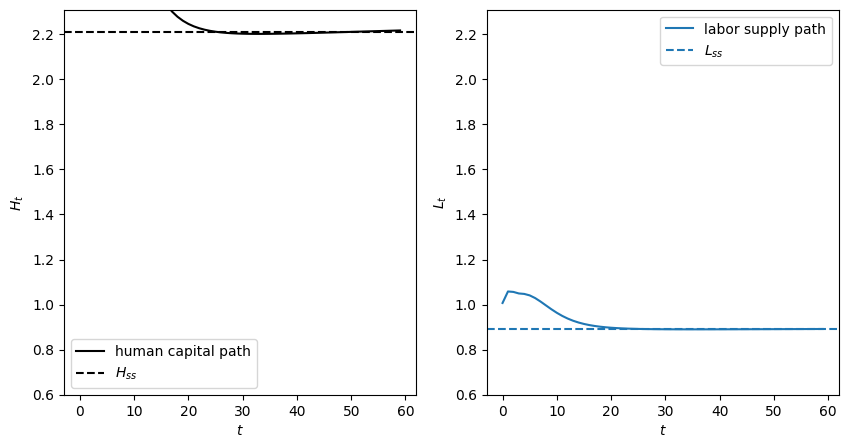

In [480]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(time_test,h_hat_path, color='k', label = "human capital path")
plt.axhline(y=SS().h_ss, linestyle='--',color='k', label = r"$H_{ss}$")
plt.ylabel(r"$H_{t}$")
plt.xlabel(r"$t$")
plt.ylim([0.6,SS().h_ss+0.1 ])
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(time_test,l_hat_path,  label = "labor supply path")
plt.axhline(y=SS().l_ss, linestyle='--', label="$L_{ss}$")
plt.ylabel(r"$L_{t}$")
plt.xlabel(r"$t$")
plt.ylim([0.6,SS().h_ss+0.1 ])
plt.legend(loc='best')
plt.show()

In [ ]:
q_hat_high = approximate_optimal_path(
    Params(),
    data=train,
    learning_rate=learning_rate,
    optimizer=optimizer,
    scheduler=scheduler,
    initial_h=4.9)

epoch , loss , loss_euler , loss_bc , loss_initial , lr_rate
0 , 1.45e+00 , 1.05e-05 , 9.18e-07 , 1.45e+01 , 1.15e-05
100 , 2.18e-02 , 8.98e-03 , 5.80e-03 , 1.41e-01 , 9.22e-06
200 , 4.73e-03 , 5.64e-03 , 2.26e-04 , 1.98e-03 , 7.38e-06
300 , 3.25e-05 , 5.88e-06 , 2.55e-04 , 2.24e-05 , 5.90e-06
400 , 6.17e-06 , 1.15e-07 , 6.07e-05 , 9.09e-11 , 4.72e-06
500 , 2.98e-06 , 7.80e-07 , 2.35e-05 , 6.48e-08 , 3.78e-06
600 , 1.35e-05 , 3.36e-07 , 1.32e-04 , 2.05e-08 , 3.02e-06
700 , 4.42e-06 , 4.78e-07 , 4.04e-05 , 8.04e-09 , 2.42e-06
800 , 2.55e-06 , 4.13e-07 , 2.22e-05 , 2.90e-09 , 1.93e-06
900 , 1.25e-06 , 4.49e-07 , 8.90e-06 , 2.90e-09 , 1.55e-06
1000 , 5.81e-07 , 2.87e-07 , 3.51e-06 , 7.13e-10 , 1.24e-06


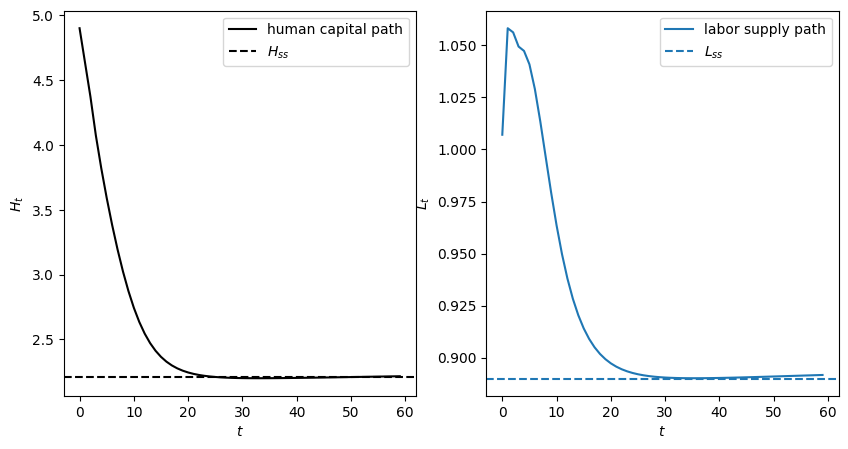

In [479]:
time_test = Grid_data().grid
l_hat_path = q_hat_high(time_test)[:,[0]].detach()
h_hat_path = q_hat_high(time_test)[:,[1]].detach()

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(time_test,h_hat_path, color='k', label = "human capital path")
plt.axhline(y=SS().h_ss, linestyle='--',color='k', label = "$H_{ss}$")
plt.ylabel(r"$H_{t}$")
plt.xlabel(r"$t$")
# plt.ylim([Params().h_0-0.1,SS().h_ss+0.1 ])
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(time_test,l_hat_path,  label = "labor supply path")
plt.axhline(y=SS().l_ss, linestyle='--', label="$L_{ss}$")
plt.ylabel(r"$L_{t}$")
plt.xlabel(r"$t$")
# plt.ylim([Params().h_0-0.1,SS().h_ss+0.1 ])
plt.legend(loc='best')
plt.show()